## Notebook 6 - Setting the CosineScore threshold

This notebooks identifies a reasonable cutoff to call hits from our screening results.

In [ ]:
%run ../common.py

In [2]:
df = pd.read_csv('./tmp/Allmixes_results_cosine_iteration_1.csv')

In [ ]:
mapElysID = pd.read_csv('../data/screening_data/ELYS_ID_to_Enzyme_name_VB.txt', sep='\t', encoding='utf8')
mapElysID = dict(zip(mapElysID.ELYS_ID, mapElysID.Enzyme_name))

In [4]:
df['Enzyme_name'] = [mapElysID.get(eid) for eid in df['Enzyme_id']]
df = df.drop('Enzyme_id', axis=1)

In [5]:
df = df[df['Enzyme_name'].isin(enzymes_inclusion)].reset_index(drop=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


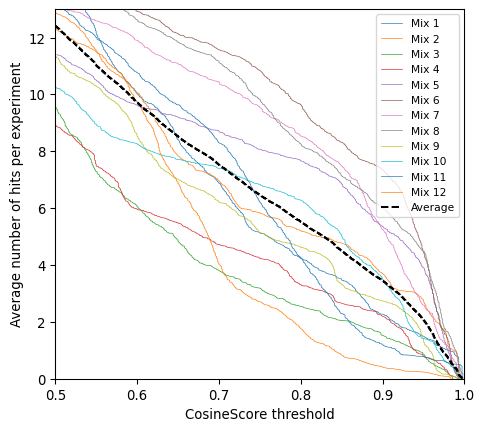

In [6]:
fig = plt.figure(figsize=(5.5, 5), dpi=96)
fig.patch.set_facecolor('white')

for mix in range(1,13):
    df_tmp = df[df['Mix']==mix]
    
    scores = df_tmp['CosineScore']
    scores = np.sort(scores)
    
    counts = np.array(range(len(scores),0,-1))
    N = len(df_tmp['File'].unique())
    counts_norm = counts / N
    
    plt.plot(scores, counts_norm, linewidth = .5)

# Let us plot the average
scores = df['CosineScore']
scores = np.sort(scores)

counts = np.array(range(len(scores),0,-1))
N = len(df['File'].unique())
counts_norm = counts / N
plt.plot(scores, counts_norm, linewidth = 1.5, color='black', linestyle='dashed')

plt.xlim([0.5,1.0])
plt.ylim([0,13])

plt.xlabel('CosineScore threshold')
plt.ylabel('Average number of hits per experiment')
legend = [f'Mix {n}' for n in range(1,13)]
legend.append('Average')
plt.legend(legend, prop={'size': 8.})

plt.savefig(filepath_results + "/figures/Effect of score cutoff.png", dpi=300, bbox_inches='tight', pad_inches=0, facecolor='white')
plt.savefig(filepath_results + "/figures/Effect of score cutoff.eps", bbox_inches='tight')
plt.show()

Let us plot by adduct type:

(0.0, 2000.0)

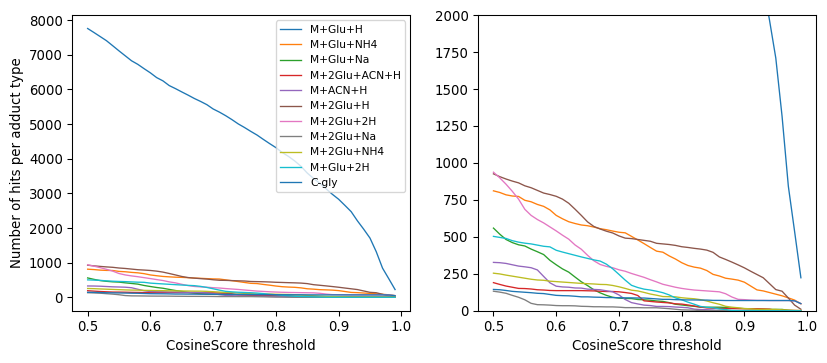

In [7]:
adducts = list(df['Adduct'].unique())
adducts.append('C-gly') # Let us plot the C-glucosides detected as well
scores = np.arange(0.5,1.0,0.01)
M = np.zeros((len(scores), len(adducts)))
for i,score in enumerate(scores):
    df_tmp = df[df['CosineScore']>=score]
    dict_counts = dict(df_tmp['Adduct'].value_counts())
    for j, adduct in enumerate(adducts):
        tmp = dict_counts.get(adduct)
        if tmp is not None:
            M[i,j] = tmp
    M[i,-1] = np.sum(df_tmp['C-gly'])

            
df_plot = pd.DataFrame(M, columns = adducts)
    
fig = plt.figure(figsize=(10, 4), dpi=96)
fig.patch.set_facecolor('white')

ax = fig.add_subplot(1, 2, 1)
for (columnName, columnData) in df_plot.items():
    plt.plot(scores, columnData.values, linewidth = 1.)
plt.legend(adducts, prop={'size': 8.})
plt.xlabel('CosineScore threshold')
plt.ylabel('Number of hits per adduct type')

ax = fig.add_subplot(1, 2, 2)
for (columnName, columnData) in df_plot.items():
    plt.plot(scores, columnData.values, linewidth = 1.)
plt.xlabel('CosineScore threshold')
plt.ylim([0,2000])

Let us drop any rows with the same enzyme and name combination:

In [8]:
df = df.sort_values(by=['Mix', 'AUC'], ascending=[True, False]) # The sorting ensures we keep the highest AUC when dropping
df = df.drop_duplicates(subset=['Enzyme_name', 'Name'], keep='first')
df.reset_index(drop=True, inplace=True)

assert not any(df['AUC']<=0) # Sanity check
# df = df.query('AUC > 10_000').reset_index(drop=True).copy()

df['single_or_double'] = df['Name'].apply(lambda x: 'double' if " (2GLC)" in x  else 'single')
df['Name'] = df['Name'].str.replace(' (2GLC)', '')

len(df)

11874

In [9]:
score_thresholds = [0.75, 0.8, 0.85, 0.9]
for score_threshold in score_thresholds:
    df = df[df['CosineScore']>=score_threshold]
    df.reset_index(drop=True, inplace=True)

    # Pivoting the dataframe
    df_pivot = df.pivot(index=['Mix', 'Name', 'CSMILES', 'Enzyme_name'], columns='single_or_double', values=['CosineScore', 'RT', 'AUC', 'Adduct', 'C-gly','MoNA_DB#']).reset_index()

    # Flattening the column hierarchy
    df_pivot.columns = ['_'.join(col).strip('_') for col in df_pivot.columns.values]

    df_pivot['single_double'] = df_pivot.apply(
        lambda row: 'single_and_double' if row['AUC_single'] > 0 and row['AUC_double'] > 0 else (
            'single' if row['AUC_single'] > 0 else (
                'double' if row['AUC_double'] > 0 else None
            )
        ), axis=1
    )

    # Specifying the desired column order
    desired_order = ['Mix', 'Name', 'CSMILES', 'Enzyme_name', 'single_double',
                    'CosineScore_single', 'RT_single', 'AUC_single', 'Adduct_single', 'C-gly_single', 'MoNA_DB#_single', 
                    'CosineScore_double', 'RT_double', 'AUC_double', 'Adduct_double', 'C-gly_double','MoNA_DB#_double',]

    # Reordering the columns
    df_pivot = df_pivot[desired_order]

    # Save the results
    df_pivot.to_pickle(filepath_results + f'Screening_results_CosineScore_{score_threshold}.pkl')
    df_pivot.to_csv(filepath_results + f'Screening_results_CosineScore_{score_threshold}.csv', index=False) # for paper

    print(score_threshold)
    print(len(df_pivot))

0.75
5542
0.8
4695
0.85
3792
0.9
2968
